### Objectif global du projet

Ce projet vise à construire un pipeline complet de traitement, prévision et détection d’anomalies sur des données industrielles (séries temporelles), en utilisant des approches statistiques et deep learning.

Ce notebook d’exploration sert à :
- **Observer**
- **Comprendre**
- **Identifier les problèmes (outliers, tendances, manquants, fréquence, etc.)**

In [2]:
import os
import sys
from pathlib import Path

#  Définir le chemin racine du projet
PROJECT_ROOT = Path("C:/Users/user/Downloads/industrial-forecasting-project")
SRC = PROJECT_ROOT / "src"

#  Ajouter 'src' au chemin Python s'il n'y est pas déjà
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

#  Maintenant les imports fonctionnent
from industrial_forecasting.utils.config import load_config
from industrial_forecasting.data import load_series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Style graphique
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("deep")
pd.options.display.float_format = '{:,.3f}'.format

#  Charger la config
cfg = load_config(PROJECT_ROOT / "config.yaml")
print(" Configuration chargée")


 Configuration chargée


### 1. Chargement et préparation des données

In [3]:
# Chargement de la série
a = load_series(
    cfg.data.raw_path,
    cfg.data.datetime_col,
    cfg.data.value_col,
    cfg.data.freq,
)
a = a.dropna()
df = a.rename("value").to_frame().reset_index(names="timestamp")
df = df.set_index("timestamp").sort_index()
s = df["value"]  # Série temporelle propre
print(f"Série chargée : {len(df)} observations")
print(s.head(10))
print(df.head())

Série chargée : 7267 observations
timestamp
2013-07-04 00:00:00   69.881
2013-07-04 01:00:00   71.220
2013-07-04 02:00:00   70.878
2013-07-04 03:00:00   68.959
2013-07-04 04:00:00   69.284
2013-07-04 05:00:00   70.061
2013-07-04 06:00:00   69.280
2013-07-04 07:00:00   69.370
2013-07-04 08:00:00   69.167
2013-07-04 09:00:00   68.986
Name: value, dtype: float64
                     value
timestamp                 
2013-07-04 00:00:00 69.881
2013-07-04 01:00:00 71.220
2013-07-04 02:00:00 70.878
2013-07-04 03:00:00 68.959
2013-07-04 04:00:00 69.284


In [4]:
# Enregistrer le DataFrame dans un fichier CSV
output_path = "C:/Users/user/Downloads/industrial-forecasting-project/data/processed/series_cleaned.csv"
df.to_csv(output_path, index=True)  # Inclut l'index dans le fichier

print(f"Le DataFrame a été enregistré avec succès dans : {output_path}")

Le DataFrame a été enregistré avec succès dans : C:/Users/user/Downloads/industrial-forecasting-project/data/processed/series_cleaned.csv


### 4. Exploration des données

#### Statistiques descriptives

In [5]:

print("Aperçu des métadonnées :")
print(f"Période : {s.index.min()} → {s.index.max()}")
print(f"Fréquence détectée : {pd.infer_freq(s.index)}")
print(f"Valeurs manquantes : {s.isna().sum()}")
display(s.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))


Aperçu des métadonnées :
Période : 2013-07-04 00:00:00 → 2014-05-28 15:00:00
Fréquence détectée : None
Valeurs manquantes : 0


count   7,267.000
mean       71.242
std         4.248
min        57.458
1%         60.847
5%         63.660
25%        68.369
50%        71.858
75%        74.431
95%        77.035
99%        79.219
max        86.223
Name: value, dtype: float64

##### Interprétation :
- La série semble propre et complète
- Quelques outliers extrêmes possibles (valeurs > 85 ou < 60)
- Il y a une variabilité assez nette (std = 4.25)

#### Visualisations générales

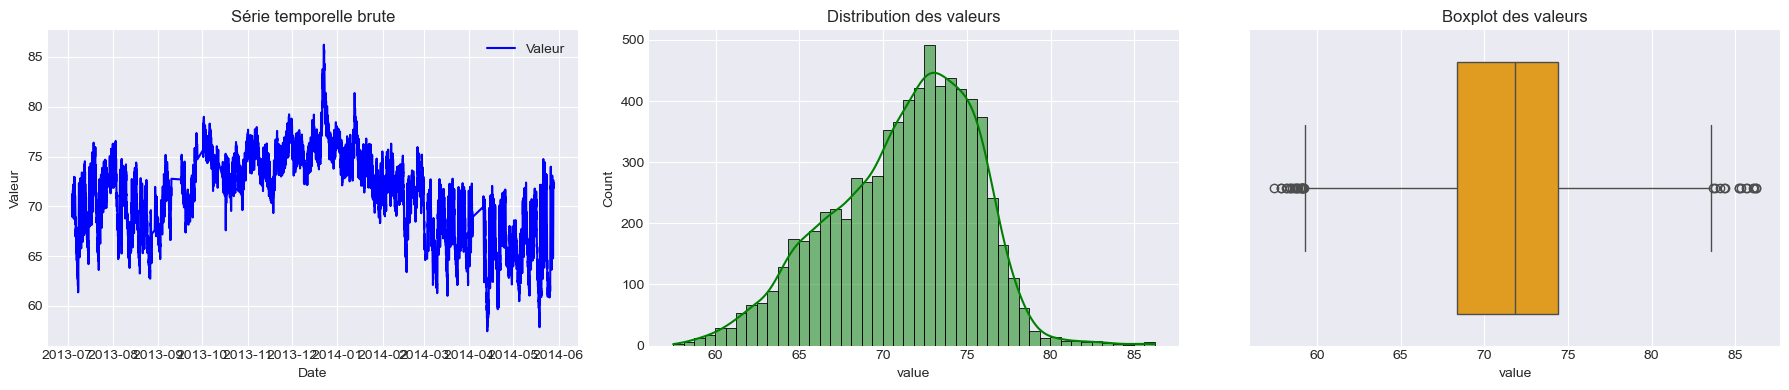

In [6]:
plt.figure(figsize=(18, 4))

# 1. Série temporelle brute
plt.subplot(1, 3, 1)
plt.plot(df.index, df['value'], label='Valeur', color='blue')
plt.title("Série temporelle brute")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)

# 2. Histogramme + KDE
plt.subplot(1, 3, 2)
sns.histplot(df['value'], kde=True, color='green')
plt.title("Distribution des valeurs")

# 3. Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(x=df['value'], color='orange')
plt.title("Boxplot des valeurs")

plt.tight_layout()
plt.show()


#### Interpretation 
a) Série temporelle brute :  Montre la dynamique temporelle brute, avec des fluctuations régulières

b) Histogramme : Distribution globale centrée autour de la moyenne (approx. normale)

c) Boxplot : Montre quelques valeurs extrêmes, potentiellement des anomalies

### 5. Analyse temporelle

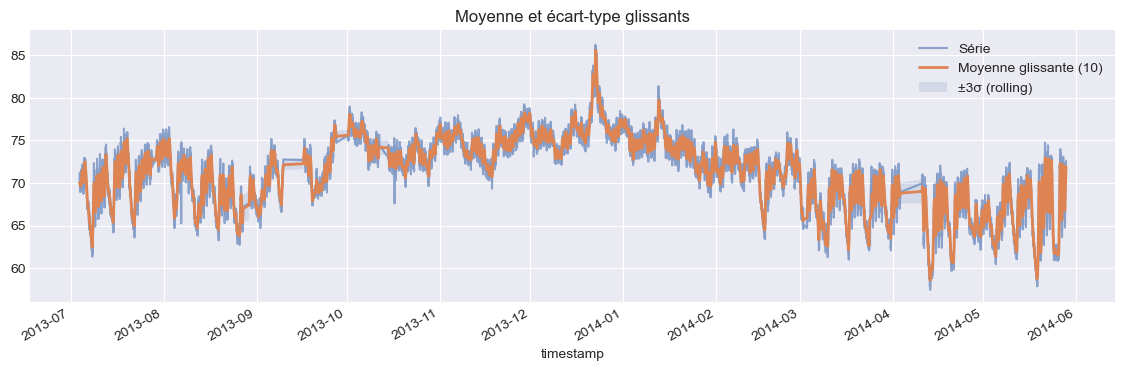

In [7]:
# Moyennes glissantes
win = 10
rolling_mean = s.rolling(window=win, center=True, min_periods=1).mean()
rolling_std = s.rolling(window=win, center=True, min_periods=1).std()

fig, ax = plt.subplots(figsize=(14, 4))
s.plot(ax=ax, label="Série", alpha=0.6)
rolling_mean.plot(ax=ax, label=f"Moyenne glissante ({win})", linewidth=2)
ax.fill_between(
    rolling_mean.index,
    rolling_mean - rolling_std,
    rolling_mean + rolling_std,
    alpha=0.15, label="±3σ (rolling)"
)
ax.set_title("Moyenne et écart-type glissants")
ax.legend()
plt.show()

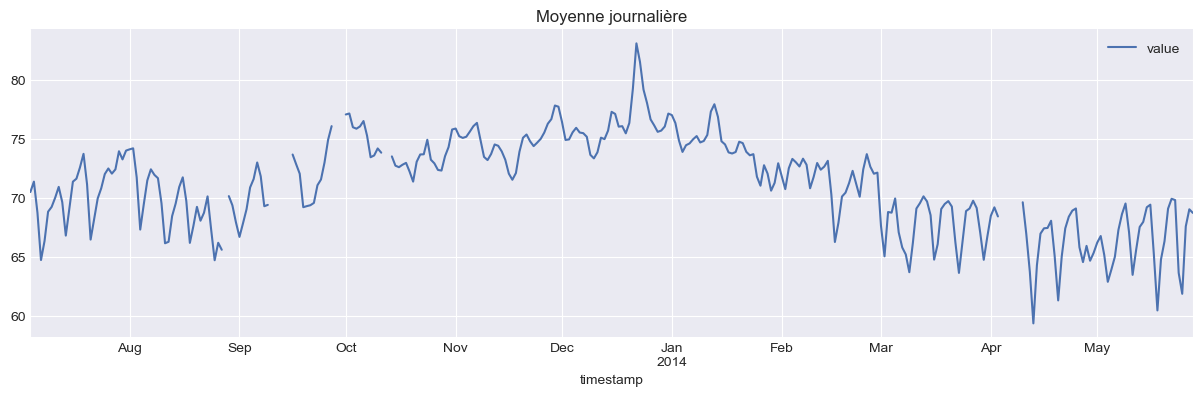

In [8]:
df.resample('D').mean().plot(figsize=(15, 4), title='Moyenne journalière')
plt.show()

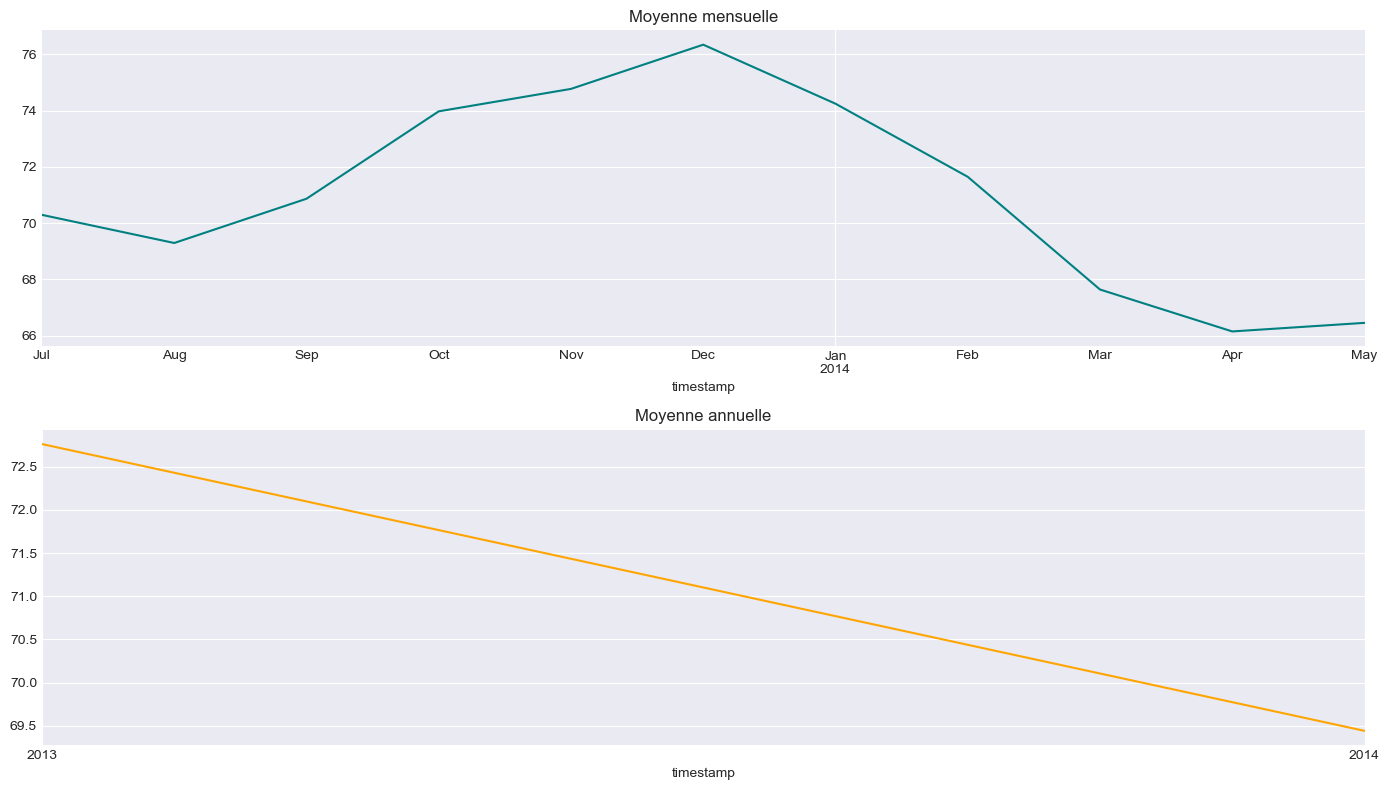

In [9]:
## Creation des agregations mensuelles et annuelles
### Regroupe les données par mois ou année pour observer les tendances à long terme.
monthly = s.resample('ME').mean()
yearly  = s.resample('YE').mean()

fig, ax = plt.subplots(2,1, figsize=(14,8))
monthly.plot(ax=ax[0], title="Moyenne mensuelle", color="teal")
yearly.plot(ax=ax[1], title="Moyenne annuelle", color="orange")
plt.tight_layout()
plt.show()

a) Moyenne glissante ± écart-type : Visualisation de la tendance locale et de la volatilité

**Interprétation:**
- La moyenne suit bien la structure de la série
- L’écart-type varie dans le temps : plus instable autour de janvier 2014
- La série a probablement une tendance et une saisonnalité

b) Agrégation journalière / mensuelle / annuelle : Sert à observer les cycles longs

**Interprétation:**
- On observe une montée jusqu’à fin 2013, suivie d’une baisse
- indice d’un cycle saisonnier (hiver ?)

### 6. Detection des anomalies

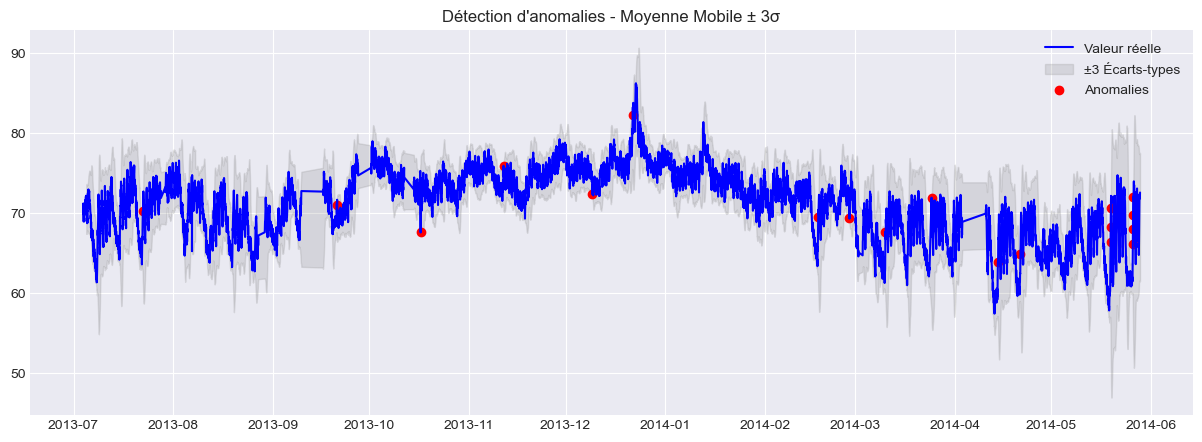

In [10]:
# Détection des anomalies
rolling_mean = s.rolling(window=24).mean()
rolling_std = s.rolling(window=24).std()
upper_limit = rolling_mean + 3 * rolling_std
lower_limit = rolling_mean - 3 * rolling_std
anomalies = df[(s > upper_limit) | (s < lower_limit)]

# Visualisation des anomalies
plt.figure(figsize=(15, 5))
plt.plot(s, label="Valeur réelle", color="blue")
plt.fill_between(df.index, lower_limit, upper_limit, color="gray", alpha=0.2, label="±3 Écarts-types")
plt.scatter(anomalies.index, anomalies["value"], color="red", label="Anomalies")
plt.legend()
plt.title("Détection d'anomalies - Moyenne Mobile ± 3σ")
plt.show()



### 7. Analyse avancée

#### Test de stationnarité ADF

In [11]:
result = adfuller( df["value"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print(" Série stationnaire")
else:
    print(" Série non stationnaire ")

ADF Statistic: -5.517563052178541
p-value: 1.909754729598087e-06
 Série stationnaire


**Interprétation:**
- La série est stationnaire
- Nous pouvons donc considérer qu'il n'ya pas de différenciation (d = 0).

#### Lecture des ACF / PACF



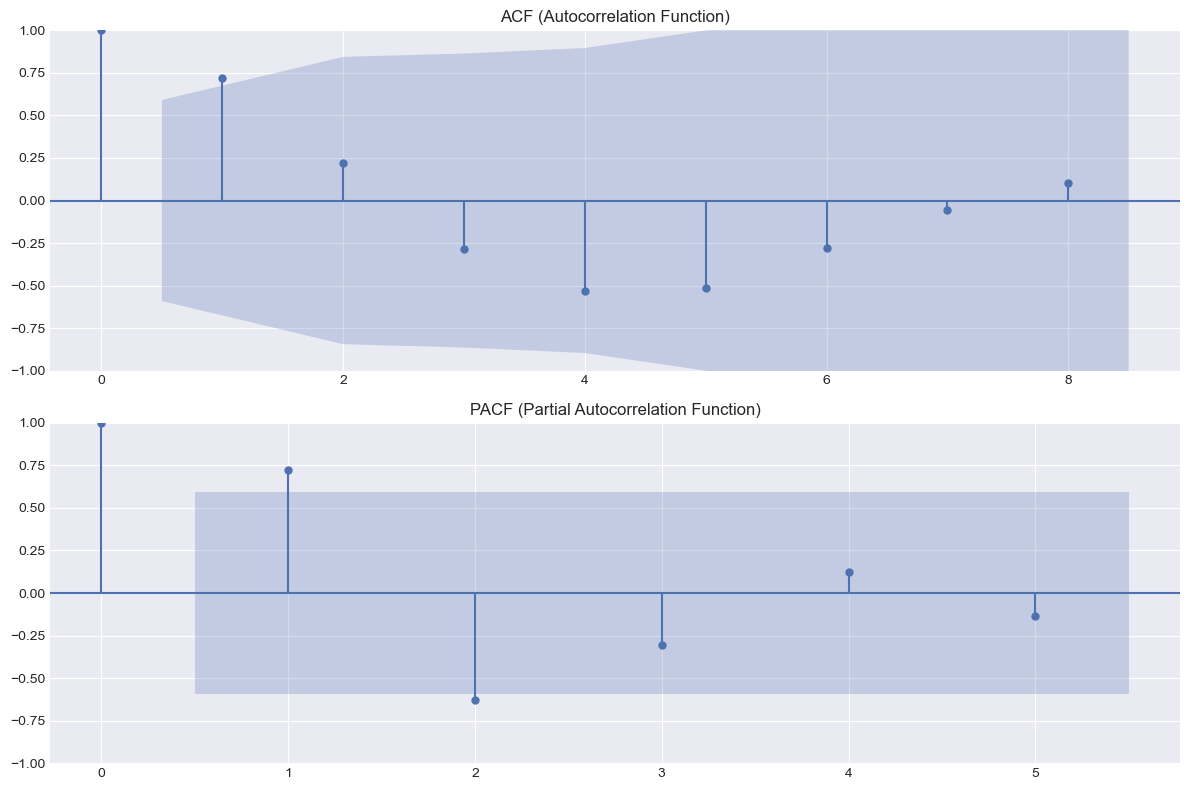

In [12]:


# Vérification des données mensuelles
if "value" in df.columns:
    df_monthly = df["value"].resample("ME").mean()  # Agrégation mensuelle
else:
    raise ValueError("La colonne 'value' est absente du DataFrame.")

# Vérification des données non nulles
if df_monthly.isnull().sum() > 0:
    print("Attention : des valeurs manquantes sont présentes dans les données mensuelles.")
    df_monthly = df_monthly.dropna()

# Tracé des ACF et PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(df_monthly, lags=8, ax=ax[0])
ax[0].set_title("ACF (Autocorrelation Function)")

# PACF
plot_pacf(df_monthly, lags=5, ax=ax[1], method="ywm")
ax[1].set_title("PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()

- PACF :
  - Lag 1 fortement positif
  - Lag 2 négatif
  - Lags > 2 non significatifs → AR(p=2)

- ACF :
  - Corrélation jusqu’à lag 2
  - Pas de décroissance lente → MA(q=2)

- Interprétation : Modèle ARIMA(p=2, d=0, q=2) est justifié.

#### Tendance et saisonalité

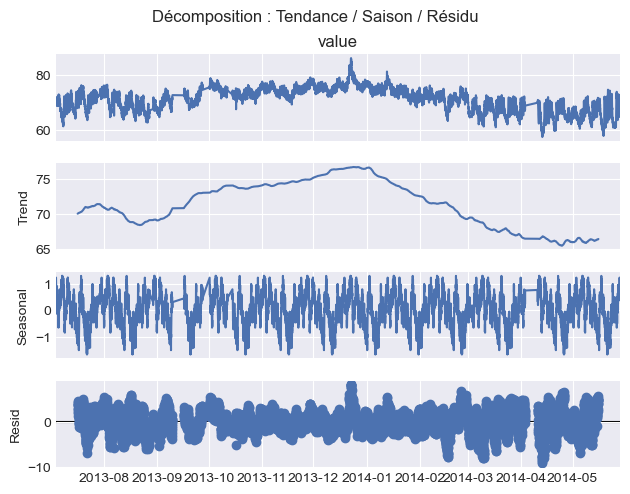

In [13]:
result = seasonal_decompose( s, model='additive', period=max(2, int(len(s)/12)))
result.plot()
plt.suptitle("Décomposition : Tendance / Saison / Résidu", y=1.02)
plt.show()

- Composantes :

  - Tendance : montée puis descente, cohérente avec les moyennes mensuelles.

  - Saison : oscillations courtes → probablement journalières.

  - Résidus : bruit aléatoire.

- Interprétation :

  - Tendance et saisonnalité bien capturées.
  - Bonne base pour un modèle ARIMA ou LSTM.